In [197]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings 
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast
from statsforecast.models import (
    Naive,WindowAverage,
    AutoARIMA,SeasonalNaive,HoltWinters,
    CrostonClassic as Croston, HistoricAverage,DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

warnings.filterwarnings("ignore")  # To ignore warnings from pandas/numpy

In [198]:
user="Lilian"

In [199]:
def get_models():

    models = [
        Naive(), HistoricAverage(), WindowAverage(window_size=4),
        SeasonalNaive(season_length=4), AutoARIMA(seasonal=False,alias="ARIMA"),
        AutoARIMA(seasonal=True,season_length=4,alias="SARIMA"),
        HoltWinters(season_length=4), DOT(season_length=4),
    ]
    return models

def train_and_forecast(df,target_name, h=8):
    
    sf=StatsForecast(models=get_models(),freq='QS', n_jobs=-1,fallback_model=SeasonalNaive(season_length=4))
    
    forecasts_df=sf.forecast(df=df, h=h, level=[95])
    return forecasts_df, sf

def evaluate_train_test(df,target_name,train_size=None, test_size=8, h=8):

    if train_size is None:
        train = df.groupby('unique_id').apply(lambda x: x.iloc[:-test_size]).reset_index(drop=True)
    else:
        # This takes the last (train_size + test_size) observations, then splits them
        train = df.groupby('unique_id').apply(
            lambda x: x.iloc[-(train_size + test_size):-test_size]).reset_index(drop=True)
    
    test = df.groupby('unique_id').apply(lambda x: x.iloc[-test_size:]).reset_index(drop=True)
    
    # Fit models on training data
    sf = StatsForecast(models=get_models(), freq='QS', n_jobs=-1, fallback_model=SeasonalNaive(season_length=4))
    sf.fit(df=train)
    preds = sf.predict(h=h)

    preds_df = pd.merge(test, preds.reset_index(), on=['ds', 'unique_id'], how='left')
    models = [col for col in preds.columns if col not in ['unique_id', 'ds']]
    
    eval_df = evaluate(preds_df,metrics=[mae, mse, rmse], models=models
    )
    
    mae_df = eval_df[eval_df['metric'] == 'mae'].copy()
    mae_df['best_model'] = mae_df[models].idxmin(axis=1)
    
    print(f"\n📈 Best Models (Train-Test Split - based on MAE):")
    print(mae_df['best_model'].value_counts())
    
    return eval_df, preds_df, train, test    

def evaluate_model_cross(df,target_name,n_windows=5, h=8):
    
    sf = StatsForecast(models=get_models(), freq='QS', n_jobs=-1, fallback_model=SeasonalNaive(season_length=4))

    print(f"   Running cross-validation...")
    cv_df = sf.cross_validation(df=df, h=h, n_windows=n_windows, step_size=h)
    models = [col for col in cv_df.columns if col not in ['unique_id', 'ds', 'y', 'cutoff']]

    eval_df = evaluate(cv_df, metrics=[mae, mse, rmse], models=models)
    mae_df = eval_df[eval_df['metric'] == 'mae'].copy()
    mae_df['best_model'] = mae_df[models].idxmin(axis=1)

    print(mae_df['best_model'].value_counts())
    
    return eval_df, cv_df, mae_df

def get_best_model_forecast(forecasts_df,evaluation_df_summary, add_cv_metrics=True):

    if 'unique_id' not in forecasts_df.columns:
        forecasts_df = forecasts_df.reset_index()
    
    # Get best model info
    best_info = evaluation_df_summary[['unique_id', 'best_model']].drop_duplicates()
    
    # If add_cv_metrics, get all model MAE scores
    if add_cv_metrics:
        # Get all model columns (MAE scores)
        model_cols = [col for col in evaluation_df_summary.columns 
                     if col not in ['unique_id', 'best_model', 'metric']]
        cv_metrics = evaluation_df_summary[['unique_id'] + model_cols].drop_duplicates()
    
    # Initialize result dataframe
    result_rows = []
    
    # Process each unique_id
    for uid in forecasts_df['unique_id'].unique():
        # Get forecasts for this unique_id
        uid_forecasts = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        # Get best model for this unique_id
        best_model_row = best_info[best_info['unique_id'] == uid]
        
        if len(best_model_row) == 0:
            print(f"Warning: No best model found for {uid}, skipping")
            continue
        
        best_model = best_model_row['best_model'].values[0]
        
        # Get CV metrics for this unique_id
        if add_cv_metrics:
            cv_metrics_row = cv_metrics[cv_metrics['unique_id'] == uid]
        
        # For each forecast period
        for _, row in uid_forecasts.iterrows():
            result_row = {
                'unique_id': uid,
                'ds': row['ds'],
                'best_model': best_model,
                'best_forecast': row.get(best_model, np.nan)
            }

            for level in [95]:
                lo_col_source = f'{best_model}-lo-{level}'
                hi_col_source = f'{best_model}-hi-{level}'
                
                result_row[f'best_forecast-lo-{level}'] = row.get(lo_col_source, np.nan)
                result_row[f'best_forecast-hi-{level}'] = row.get(hi_col_source, np.nan)
            
            # Add CV metrics (MAE for each model)
            if add_cv_metrics and len(cv_metrics_row) > 0:
                for model_col in model_cols:
                    result_row[f'cv_mae_{model_col}'] = cv_metrics_row[model_col].values[0]
            
            result_rows.append(result_row)
    
    result = pd.DataFrame(result_rows)
    
    return result

def save_results(forecasts_df, best_forecasts_df, evaluation_cv_df, evaluation_traintest_df, target_name, save_path=None):
    
    if save_path is None or save_path == "":
        save_path = os.getcwd()
    
    # Create directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    prefix = target_name.lower().replace(' ', '_')
    
    forecasts_df.reset_index().to_csv(
        os.path.join(save_path, f"{prefix}_all_model_forecasts.csv"), index=False
    )
    best_forecasts_df.to_csv(
        os.path.join(save_path, f"{prefix}_best_model_forecasts.csv"), index=False
    )
    evaluation_cv_df.to_csv(
        os.path.join(save_path, f"{prefix}_model_evaluation_cv.csv"), index=False
    )
    evaluation_traintest_df.to_csv(
        os.path.join(save_path, f"{prefix}_model_evaluation_traintest.csv"), index=False
    )
    
    print(f"✓ Results saved to: {save_path}")
    
def plot_sample_forecasts(df,forecasts_df,target_name,n_samples=6, models_to_plot=None):

    unique_ids = df['unique_id'].unique()
    sample_ids = np.random.choice(unique_ids, min(n_samples, len(unique_ids)), replace=False)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    forecast_cols = forecasts_df.columns.tolist()
    available_models = [col for col in forecast_cols if col not in ['unique_id', 'ds'] 
                        and not col.endswith(('-lo-80', '-hi-80', '-lo-95', '-hi-95'))]
    
    # If models_to_plot is specified, filter to only those models
    if models_to_plot is not None:
        available_models = [m for m in available_models if m in models_to_plot]
    
    palette = plt.cm.get_cmap('viridis', len(available_models))
    model_styles = {
        model: {'color': palette(idx), 'marker': '.', 'linestyle': '-'}
        for idx, model in enumerate(available_models)
    }
    
    for idx, uid in enumerate(sample_ids):
        ax = axes[idx]
        
        # Historical data
        hist_data = df[df['unique_id'] == uid]
        ax.plot(hist_data['ds'], hist_data['y'], 'o-', 
                label='Historical', linewidth=1.5, color='grey', markersize=3)
        
        # Forecast data
        forecast_data = forecasts_df.reset_index()
        forecast_data = forecast_data[forecast_data['unique_id'] == uid]
        
        # Plot each available model (if you want to limit models, just specify when calling the function in main())
        for model in available_models:
            if model in forecast_data.columns:
                style = model_styles.get(model, {'color': 'gray', 'marker': 'o', 'linestyle': '-'})
                ax.plot(forecast_data['ds'], forecast_data[model], 
                       marker=style['marker'], 
                       linestyle=style['linestyle'],
                       color=style['color'],
                       label=model, 
                       linewidth=1.5,
                       markersize=3)
        
        ax.set_title(f'{uid}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel(target_name)
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    filename = f'{target_name.lower().replace(" ", "_")}_sample_forecasts.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Plot saved: {filename}")
    plt.show()
    plt.close()

def plot_train_test_forecasts(df,train_df,test_df,preds_df,target_name,ids_to_plot=None,n_samples=4, models_to_plot=None):

    if ids_to_plot is None:
        unique_ids = df['unique_id'].unique()
        ids_to_plot = np.random.choice(unique_ids, min(n_samples, len(unique_ids)), replace=False)
    
    n_plots = len(ids_to_plot)
    n_cols = 2
    n_rows = (n_plots + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Get available models from preds_df
    all_model_cols = [col for col in preds_df.columns if col not in ['unique_id', 'ds', 'y', 'cutoff']]
    
    # Filter to selected models if specified
    if models_to_plot is not None:
        model_cols = [m for m in all_model_cols if m in models_to_plot]
    else:
        model_cols = all_model_cols
    
    for idx, uid in enumerate(ids_to_plot):
        ax = axes[idx]
        
        # Get data for this unique_id
        hist_data = df[df['unique_id'] == uid].sort_values('ds')
        train_data = train_df[train_df['unique_id'] == uid].sort_values('ds')
        test_data = test_df[test_df['unique_id'] == uid].sort_values('ds')
        pred_data = preds_df[preds_df['unique_id'] == uid].sort_values('ds')
        
        # Plot training data (historical)
        ax.plot(train_data['ds'], train_data['y'], 
                'o-', color='black', linewidth=2, markersize=5, 
                label='Training Data (Historical)', zorder=3)
        
        # Plot ACTUAL test data (this is the key - the real values in the test period)
        ax.plot(test_data['ds'], test_data['y'], 
                'o-', color='darkgreen', linewidth=2.5, markersize=7, 
                label='Actual Test Values', zorder=5)
        
        # Plot predictions for each selected model
        palette = plt.cm.get_cmap('tab10', len(model_cols))
        for model_idx, model in enumerate(model_cols):
            if model in pred_data.columns:
                ax.plot(pred_data['ds'], pred_data[model], 
                       's--', color=palette(model_idx), linewidth=2, 
                       markersize=6, label=f'{model} Predicted', 
                       alpha=0.8, zorder=4)
        
        # Add vertical line to separate train/test
        if len(train_data) > 0:
            train_end = train_data['ds'].max()
            ax.axvline(x=train_end, color='red', linestyle=':', linewidth=2.5, 
                      label='Train/Test Split', alpha=0.7, zorder=2)
        
        # Add shaded region for test period
        if len(test_data) > 0:
            test_start = test_data['ds'].min()
            test_end = test_data['ds'].max()
            ax.axvspan(test_start, test_end, alpha=0.1, color='yellow', 
                      label='Test Period', zorder=1)
        
        ax.set_title(f'{uid}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel(target_name, fontsize=10)
        ax.legend(loc='best', fontsize=8, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    # Hide extra subplots if n_plots is odd
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    filename = f'{target_name.lower().replace(" ", "_")}_train_test_forecasts.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"✓ Train/Test plot saved: {filename}")
    plt.show()
    plt.close()

### Population Forecast

In [200]:
def load_data(filepath, states=None):
    
    df=pd.read_csv(filepath)
    if states is not None:
        if isinstance(states, str):
            states = [states]
        print(f"Filtering data for states: {states}")
        df = df[df['State'].isin(states)].copy()
        print(f"Filtered to {len(df)} rows across {df['State'].unique()} state(s)")
        if len(df) == 0:
            raise ValueError("No data available after filtering by states.")    
    
    df['unique_id']=df['State']
    df['ds']=pd.to_datetime(df['Period'])
    df=df.sort_values(['unique_id','ds']).reset_index(drop=True)
    df_pop=df[['unique_id','ds','Population']].copy()
    df_pop.columns = ['unique_id', 'ds', 'y']
    

    return df_pop,df

In [201]:
def main_pop(filepath, states=None, h=8, run_cv=True, n_windows=4, save_path=None):
    
    print("\n1. Loading and preparing pop data")
    df_pop,df_original=load_data(filepath, states=states)

    print(f"\nTotal states: {df_pop['unique_id'].nunique()})")
    min_date=df_pop['ds'].min(); max_date=df_pop['ds'].max()
    print(f"Date range: {min_date.year}-Q{min_date.quarter} to {max_date.year}-Q{max_date.quarter}")
    if states is not None:
        print(f"States included: {states}")

    print("\n2. Training models and generating forecasts for Population")
    forecasts_pop, sf_pop = train_and_forecast(df_pop, "Population", h=h)

    print("\n3. Evaluating models on training/test split for Population")
    eval_traintest_pop, preds_traintest_pop, train_pop, test_pop = evaluate_train_test(
        df_pop, "Population", train_size=32, test_size=h, h=h)

    if run_cv:

        print("\n4. Running cross-validation for Population...")
        eval_cv_pop, cv_pop, mae_summary_pop = evaluate_model_cross(
            df_pop, "Population", n_windows=n_windows, h=h)
        
        print("\n5. Selecting best model forecasts for Population...")
        best_forecasts_pop = get_best_model_forecast(forecasts_pop, mae_summary_pop, add_cv_metrics=True)

        print("\n6. Saving results for Population...")
        save_results(forecasts_pop, best_forecasts_pop, 
            eval_cv_pop, eval_traintest_pop, "Population", save_path=save_path)
    else:
        eval_cv_pop = None
        best_forecasts_pop=forecasts_pop.reset_index()
        print("Skipping cross-validation")
    
    #plot sample forecasts
    # plot_sample_forecasts(df_pop, forecasts_pop, "Population", n_samples=6, models_to_plot=['WindowAverage','Naive'])
    plot_train_test_forecasts(
    df=df_pop,
    train_df=train_pop,  # You'll need to return this from evaluate_train_test
    test_df=test_pop,    
    preds_df=preds_traintest_pop,
    target_name="Population",
    ids_to_plot=['IN', 'MI', 'IL', 'OH'],  # Specific states
    n_samples=4,
    models_to_plot=['WindowAverage','Naive','SARIMA']
)

    print("\n7. Compiling all results..."); print("✓ Done!")
    return {
        'population': {
            'forecasts': forecasts_pop,
            'best_forecasts': best_forecasts_pop,
            'evaluation_cv': eval_cv_pop,
            'evaluation_traintest': eval_traintest_pop,
            'predictions_traintest': preds_traintest_pop,
        }
    }



1. Loading and preparing pop data
Filtering data for states: ['IN', 'MI', 'IL', 'OH']
Filtered to 176 rows across ['IL' 'IN' 'MI' 'OH'] state(s)

Total states: 4)
Date range: 2014-Q1 to 2024-Q4
States included: ['IN', 'MI', 'IL', 'OH']

2. Training models and generating forecasts for Population

3. Evaluating models on training/test split for Population

📈 Best Models (Train-Test Split - based on MAE):
best_model
WindowAverage    4
Name: count, dtype: int64

4. Running cross-validation for Population...
   Running cross-validation...
best_model
Naive                    6
WindowAverage            4
HoltWinters              3
ARIMA                    2
DynamicOptimizedTheta    1
Name: count, dtype: int64

5. Selecting best model forecasts for Population...

6. Saving results for Population...
✓ Results saved to: C:\Users\Lilian\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\Pop\\
✓ Train/Test plot saved: population_train_test_forecasts.png


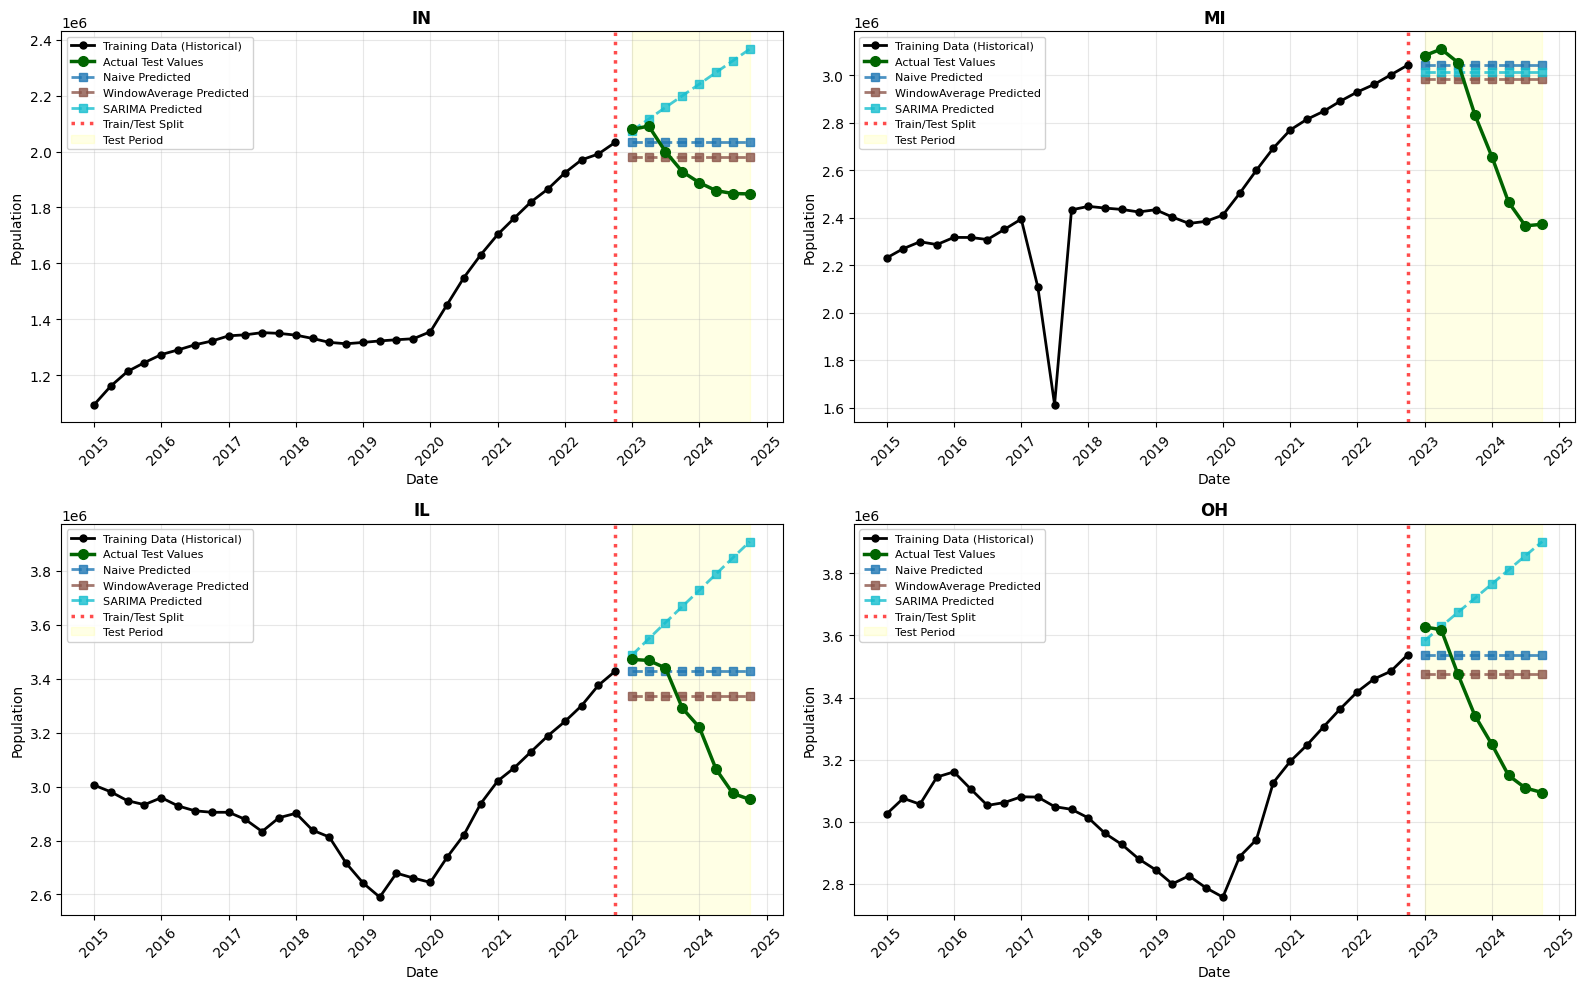


7. Compiling all results...
✓ Done!


In [202]:
pop_csv_path=rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\Prebuilt_panels\medi_pop.csv"
pop_save_path=rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\Pop\\"

results_pop=main_pop(
    filepath=pop_csv_path, states=['IN','MI','IL','OH'], h=8, run_cv=True, n_windows=4, save_path=pop_save_path
)

### Statistical Models - Dataset with pop

In [203]:
def load_and_prepare_data(filepath, states=None):

    df = pd.read_csv(filepath)
    
    if states is not None:
        if isinstance(states, str):
            states = [states]
        print(f"Filtering data for states: {states}")
        df=df[df['State'].isin(states)].copy()
        print(f"Filtered to {len(df)} rows across {df['State'].nunique()} state(s).")

        if len(df) == 0:
            raise ValueError("No data available for the specified states.")
    
    df['unique_id'] = df['State'] + '_' + df['ATC2 Class']
    df['ds'] = pd.to_datetime(df['Period'])
    df = df.sort_values(['unique_id','ds']).reset_index(drop=True)

    #Preparing dataframes for statsforecast
    df_units=df[['unique_id','ds','Units Reimbursed']].copy()
    df_units.columns=['unique_id','ds','y']

    df_prescriptions=df[['unique_id','ds','Number of Prescriptions']].copy()
    df_prescriptions.columns=['unique_id','ds','y']

    return df_units, df_prescriptions, df

In [204]:
def main(filepath, states=None, h=8, run_cv=True, n_windows=5,save_path=None):

    print("\n1. Loading and preparing data...")
    df_units, df_prescriptions, df_original = load_and_prepare_data(filepath, states=states)
    
    # Display summary
    print(f"\nData Summary:")
    print(f"  • Total unique series: {df_units['unique_id'].nunique()}")
    min_date = df_units['ds'].min()
    max_date = df_units['ds'].max()
    print(f"  • Date range: {min_date.year}-Q{min_date.quarter} to {max_date.year}-Q{max_date.quarter}")
    if states is not None:
        print(f"  • Filtered states: {', '.join(states)}")
    

    print("\n" + "="*70); print("UNITS REIMBURSED"); print("="*70)
    print("\n2. Training models and generating forecasts...")
    forecasts_units, sf_units = train_and_forecast(df_units, "Units Reimbursed", h=h)

    print("\n3. Evaluating models on training/test split...")
    eval_traintest_units, preds_traintest_units = evaluate_train_test(
        df_units, "Units Reimbursed", train_size=28, test_size=h, h=h
    )
    
    if run_cv:
        print("\n4. Running cross-validation...")
        eval_cv_units, cv_units, eval_summary_units = evaluate_model_cross(
            df_units, "Units Reimbursed", n_windows=n_windows, h=h
        )
        
        print("\n5. Selecting best forecasts...")
        best_forecasts_units = get_best_model_forecast(forecasts_units, eval_summary_units)
        
        print("\n6. Saving results...")
        save_results(forecasts_units, best_forecasts_units, 
            eval_cv_units, eval_traintest_units, 
            "Units Reimbursed", save_path=save_path
        )
    else:
        eval_units = None
        best_forecasts_units = forecasts_units.reset_index()
        print("\n Skipping cross-validation (run_cv=False)")
    
    # Plot sample forecasts
    print("\nGenerating forecast plots...")
    plot_sample_forecasts(df_units, forecasts_units, "Units Reimbursed", n_samples=4)
    

    print("\n" + "="*70); print("NUMBER OF PRESCRIPTIONS"); print("="*70)
    
    print("\n2. Training models and generating forecasts...")
    forecasts_prescriptions, sf_prescriptions = train_and_forecast(
        df_prescriptions, "Number of Prescriptions", h=h
    )

    print("\n3. Evaluating models on training/test split...")
    eval_traintest_prescriptions, preds_traintest_prescriptions = evaluate_train_test(
        df_prescriptions, "Number of Prescriptions", train_size=28, test_size=h, h=h)
    
    if run_cv:
        print("\n4. Running cross-validation...")
        eval_cv_prescriptions, cv_prescriptions, eval_summary_prescriptions = evaluate_model_cross(
            df_prescriptions, "Number of Prescriptions", n_windows=n_windows, h=h
        )
        
        print("\n5. Selecting best forecasts...")
        best_forecasts_prescriptions = get_best_model_forecast(
            forecasts_prescriptions, eval_summary_prescriptions
        )
        
        print("\n6. Saving results...")
        save_results(forecasts_prescriptions, best_forecasts_prescriptions, 
            eval_cv_prescriptions, eval_traintest_prescriptions, 
            "Number of Prescriptions", save_path=save_path
        )
    else:
        eval_prescriptions = None
        best_forecasts_prescriptions = forecasts_prescriptions.reset_index()
        print("\n Skipping cross-validation (run_cv=False)")
    
    # Plot sample forecasts
    print("\n Generating forecast plots...")
    plot_sample_forecasts(
        df_prescriptions, 
        forecasts_prescriptions, 
        "Number of Prescriptions", 
        n_samples=4
    )
    
    print("\n" + "="*70); print("✅ PIPELINE COMPLETE!"); print("="*70)
    
    state_info = f"{', '.join(states)}" if states else "ALL"
    print(f"\n Forecasts generated for state(s): {state_info}")
    print(f"Forecast horizon: {h} quarters ahead")
    
    if run_cv:
        print(f"\n All files generated:")
    
    # Optional: Return results for programmatic access
    return {
        'units': {
            'forecasts': forecasts_units,
            'best_forecasts': best_forecasts_units if run_cv else None,
            'evaluation_cv': eval_cv_units if run_cv else None,
            'evaluation_traintest': eval_traintest_units,
            'predictions_traintest': preds_traintest_units,
        },
        'prescriptions': {
            'forecasts': forecasts_prescriptions,
            'best_forecasts': best_forecasts_prescriptions if run_cv else None,
            'evaluation_cv': eval_cv_prescriptions if run_cv else None,
            'evaluation_traintest': eval_traintest_prescriptions,
            'predictions_traintest': preds_traintest_prescriptions,
        }
    }

In [205]:
path_save=rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\TMF\\"
os.path.isdir(path_save)

True

In [ ]:
#path to the pre-built dataset
csv_path=rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\Prebuilt_panels\P1_nopop.csv"
path_save=rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\TMF\\"

if __name__ == "__main__":
    main(filepath=csv_path, states=['IN'], h=8, run_cv=True, n_windows=5,save_path=path_save)
  